# FYP-DL: WNN - Countering Class Imbalance with Focal Loss

I'm going to use a new loss functional called focal crossentropy that was designed for imbalanced binary classification tasks.

So far, our experiments with classical binary crossentropy have shown that this loss function often prioritises correct classifications of the majority class at the expense of that of minority class.

Even with weighted loss and upsampling/downsampling, crossentropy isn't giving us the performance we want in terms of FPs and FNs.

# Imports

In [6]:
# Standard imports 
import numpy as np
import pandas as pd 
import os

# Seed random number generator for reproducible results
np.random.seed(42)

# For loading data from Drive
from google.colab import drive, files

# Plotting imports - Seaborn
from seaborn import distplot, heatmap

# Plotting imports - Matplotlib
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')

# Scikit-Learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score, roc_curve, confusion_matrix

# Have to use Tensorflow's distribution of Keras for compatibility with metrics
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Focal loss is not implemented in core Tensorflow --> in addons module
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

# Functions

In [29]:
def get_classification_result(model, X_test, y_true, model_name=None, 
                              normalize_conf_mat='all'):
  """Displays classification report, confusion matrix, and ROC curve for a trained
  model using classification results on data provided"""
  # PREDICTIONS
  # First, get the predictions for the test data
  y_pred = model.predict_classes(X_test)

  # CLASSIFICATION REPORT
  print("classification report".upper(), end='\n')
  print(classification_report(y_true, y_pred, labels=[0, 1], 
                              target_names=['Regular Consumer', 'Thief']))
  
  # CONFUSION MATRIX
  if (normalize_conf_mat=='rows'):
    normalize='true'
  elif (normalize_conf_mat=='cols'):
    normalize='pred'
  else:
    normalize='all'

  # Using Seaborn to plot confusion matrix as a heatmap 
  conf_mat = confusion_matrix(y_true, y_pred, normalize=normalize)

  # Create a heatmap in lieu of the plot_confusion_matrix call in sklearn
  plt.figure(figsize=(8, 8))
  heatmap(conf_mat, annot=True, fmt='.5g', cmap='Blues', 
        xticklabels=['Predicted Reg', 'Predicted Thief'], 
        yticklabels=['True Reg', 'True Thief'])
  plt.title('Confusion Matrix ' + ('' if model_name is None else ' - ' + model_name))

  # ROC Curve
  plt.figure(figsize=(8, 8))
  y_pred_keras = model.predict(X_test).ravel()
  fpr, tpr, _ = roc_curve(y_true, y_pred_keras, pos_label=1)
  roc_auc = roc_auc_score(y_true, y_pred_keras)
  plt.plot(fpr, tpr, lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
  plt.xlabel('False Positive Rate', fontsize=14)
  plt.ylabel('True Positive Rate', fontsize=14)
  plt.title('ROC Curve' + ('' if model_name is None else (' - ' + model_name)))
  plt.legend(loc='lower right')

In [8]:
def plot_history(history, model_name=None, figsize=(12, 6), 
                 loss_name='Binary Crossentropy'):
  # Extract loss from the history object
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  
  # Extract AUCs
  auc = None
  val_auc = None

  # Extract `auc` and `val_auc` regardless of last number in key
  for key in list(history.history.keys()):
    if 'auc' in key and 'val' not in key:
      auc = history.history[key]
    elif 'auc'in key and 'val' in key:
      val_auc = history.history[key]

  # Plotting Loss
  plt.figure(figsize=figsize)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs', fontsize=14)
  plt.ylabel(loss_name, fontsize=14)
  plt.title('Loss ' + ('' if model_name is None else ' - {}'.format(model_name)), 
            fontsize=18)
  plt.legend(loc='lower right')

  # Plotting AUC - only if in dictionary
  if auc is not None and val_auc is not None:
    plt.figure(figsize=figsize)
    plt.plot(epochs, auc, label='Training AUC')
    plt.plot(epochs, val_auc, label='Validation AUC')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('AUC', fontsize=14)
    plt.title('AUC ' + ('' if model_name is None else' - {}'.format(model_name)), 
              fontsize=18)

# Modules

In [10]:
!wget "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/pipelines.py"
!wget "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/plot_utils.py"
!wget "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/wdnn_transformers.py"
!wget "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/build_WDNN.py"

--2020-07-24 20:18:21--  https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/pipelines.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3618 (3.5K) [text/plain]
Saving to: ‘pipelines.py’

pipelines.py        100%[===================>]   3.53K  --.-KB/s    in 0s      

2020-07-24 20:18:22 (73.8 MB/s) - ‘pipelines.py’ saved [3618/3618]

--2020-07-24 20:18:24--  https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/plot_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent

# Loading Data

In [11]:
# Mount Google Drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [13]:
# Defining filepaths
ROOT_DIR = "/content/drive/My Drive"
FYP_DIR = "EE 16-17 FYP DL Energy Theft Detection"
DATA_DIR = "Data/full-processing-data"
FILE_NAME = "outliersRemoved.csv"

In [14]:
# Create filepath
FILE_PATH = os.path.join(ROOT_DIR, FYP_DIR, DATA_DIR, FILE_NAME)

In [15]:
df = pd.read_csv(FILE_PATH)
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


# Train-Test Split 

In [16]:
features, labels = df.iloc[:, 2:], df.iloc[:, 1]

In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=labels.values)

# Feature Scaling

In [19]:
# Import the pipeline functions from the pipeline modules
from pipelines import get_pipeline_1D, get_pipeline_2D

# Creating pipeline objects
pipeline_1D_std = get_pipeline_1D(scaling_strategy='Standard')
pipeline_1D_minmax = get_pipeline_1D(scaling_strategy='MinMax')

# Fit and then transform the pipelines to the training data first 
X_train_val_1D_std = pipeline_1D_std.fit_transform(X_train_val)
X_test_1D_std = pipeline_1D_std.fit_transform(X_test)

# Building WNN

In [22]:
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

In [37]:
model = Sequential()
model.add(Dense(units=90, activation='relu', input_shape=(1034, )))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss=SigmoidFocalCrossEntropy(), 
              metrics=[AUC()])

# Training Model

In [38]:
wide_history = model.fit(X_train_val, y_train_val,
                         validation_split=0.2, 
                         epochs=20, 
                         verbose=1)

Epoch 1/20
848/848 [==============================] - 4s 4ms/step - loss: 0.3067 - auc_4: 0.4573 - val_loss: 0.2341 - val_auc_4: 0.4603
Epoch 2/20
848/848 [==============================] - 3s 4ms/step - loss: 0.1930 - auc_4: 0.4760 - val_loss: 0.0880 - val_auc_4: 0.5296
Epoch 3/20
848/848 [==============================] - 4s 4ms/step - loss: 0.0666 - auc_4: 0.5133 - val_loss: 0.0537 - val_auc_4: 0.5507
Epoch 4/20
848/848 [==============================] - 3s 4ms/step - loss: 0.0498 - auc_4: 0.5410 - val_loss: 0.0470 - val_auc_4: 0.5815
Epoch 5/20
848/848 [==============================] - 4s 4ms/step - loss: 0.0466 - auc_4: 0.5669 - val_loss: 0.0510 - val_auc_4: 0.5962
Epoch 6/20
848/848 [==============================] - 3s 4ms/step - loss: 0.0443 - auc_4: 0.5984 - val_loss: 0.0676 - val_auc_4: 0.4846
Epoch 7/20
848/848 [==============================] - 4s 4ms/step - loss: 0.0449 - auc_4: 0.6174 - val_loss: 0.0403 - val_auc_4: 0.5953
Epoch 8/20
848/848 [============================

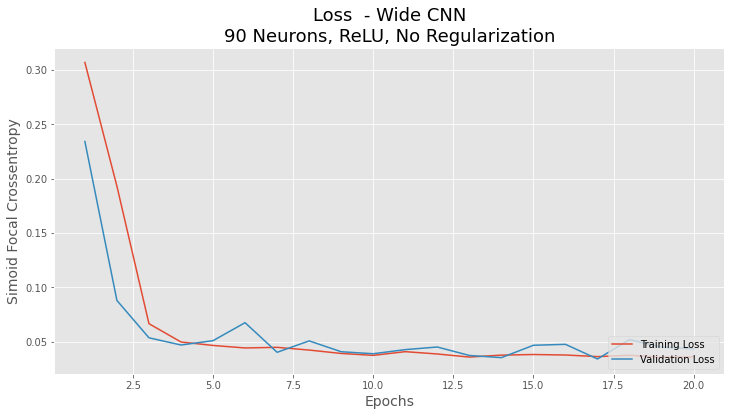

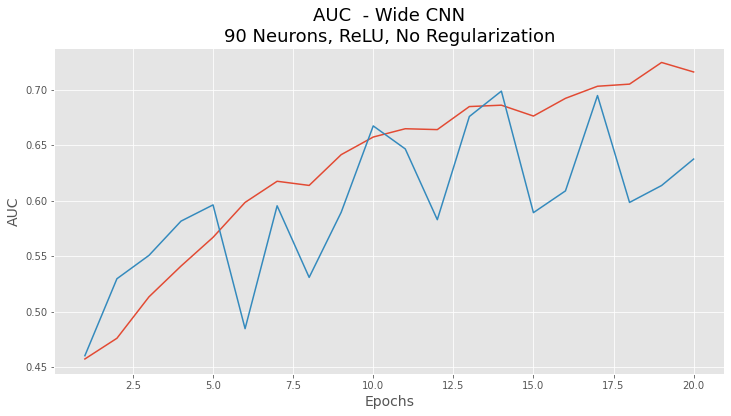

In [39]:
plot_history(history=wide_history, 
             model_name='Wide CNN\n90 Neurons, ReLU, No Regularization', 
             loss_name='Simoid Focal Crossentropy')

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
           Thief       0.61      0.07      0.12       723

        accuracy                           0.92      8475
       macro avg       0.76      0.53      0.54      8475
    weighted avg       0.89      0.92      0.88      8475



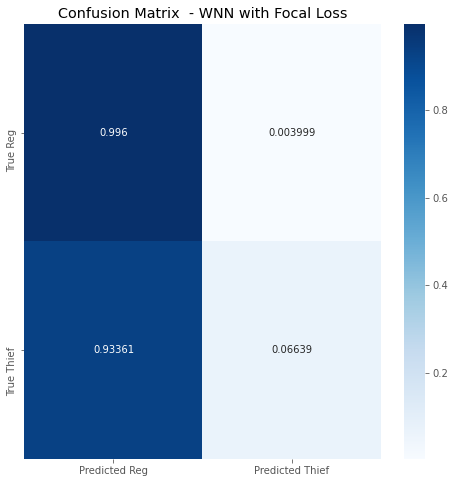

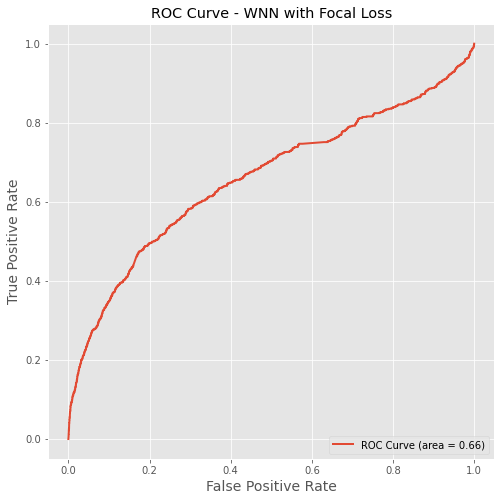

In [40]:
get_classification_result(model, X_test, y_test, 'WNN with Focal Loss', 
                          normalize_conf_mat='rows')

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
           Thief       0.61      0.07      0.12       723

        accuracy                           0.92      8475
       macro avg       0.76      0.53      0.54      8475
    weighted avg       0.89      0.92      0.88      8475



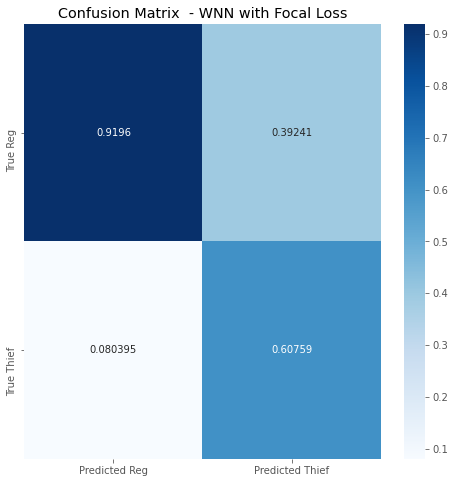

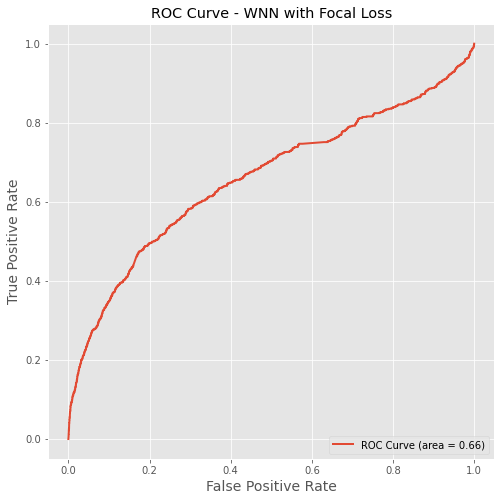

In [41]:
get_classification_result(model, X_test, y_test, 'WNN with Focal Loss', 
                          normalize_conf_mat='cols')

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
           Thief       0.61      0.07      0.12       723

        accuracy                           0.92      8475
       macro avg       0.76      0.53      0.54      8475
    weighted avg       0.89      0.92      0.88      8475



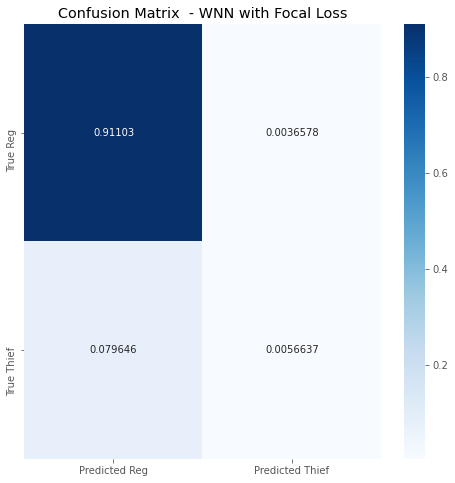

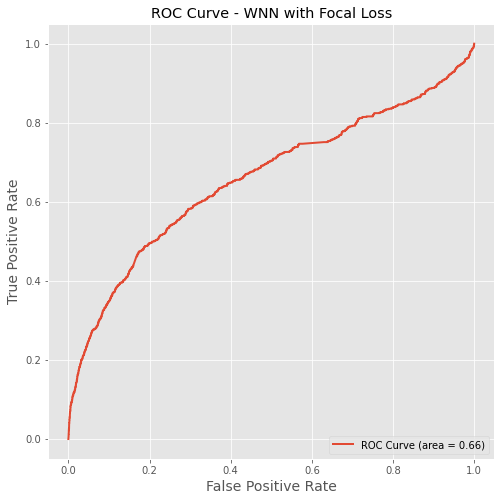

In [42]:
get_classification_result(model, X_test, y_test, 'WNN with Focal Loss')